# COGS 118C Final Project


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import ttest_ind
from mne.time_frequency import tfr_morlet
import matplotlib.pyplot as plt


In [51]:
Control = np.load("EEG_human/Control_EEG_sub_037.npy")
AD = np.load("EEG_human/AD_EEG_sub_001.npy")

In [4]:
processed_Control = np.load("EEG_human/Control_EEG_sub_037_processed.npy")
processed_AD = np.load("EEG_human/AD_EEG_sub_001_processed.npy")

In [52]:
print(processed_AD.shape)
print(AD.shape)

(3, 150000)
(3, 150000)


In [5]:
fs = 500  # Sampling rate (Hz)

## Power spectrum

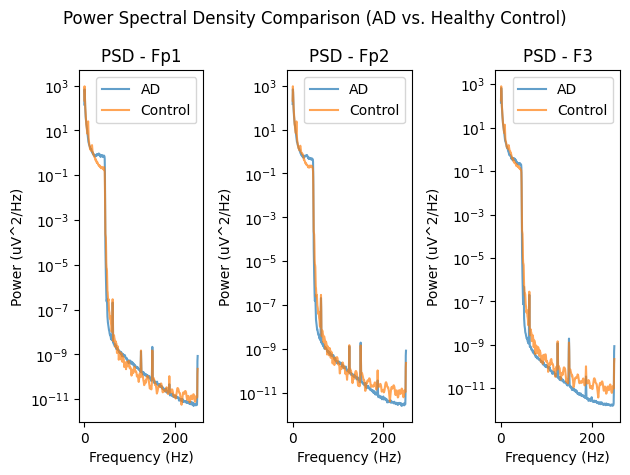

In [6]:
bands = { "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 100), }

for i, channel in enumerate(["Fp1", "Fp2", "F3"]):
    # Compute PSD using Welch's method
    f_ad, psd_ad = welch(processed_AD[i], fs, nperseg=fs*2)
    f_control, psd_control = welch(processed_Control[i], fs, nperseg=fs*2)

    # Plot
    plt.subplot(1, 3, i + 1)
    plt.semilogy(f_ad, psd_ad, label="AD", alpha=0.7)
    plt.semilogy(f_control, psd_control, label="Control", alpha=0.7)
    plt.title(f"PSD - {channel}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (uV^2/Hz)")
    plt.legend()

plt.suptitle("Power Spectral Density Comparison (AD vs. Healthy Control)")
plt.tight_layout()
plt.show()

In [7]:
# Function to compute relative power in different EEG bands
def compute_band_power(psd, freqs, bands):
    band_power = {}
    total_power = np.trapz(psd, freqs)  # Total power across all frequencies

    for band, (low, high) in bands.items():
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        band_power[band] = np.trapz(psd[idx_band], freqs[idx_band]) / total_power  # Relative power

    return band_power

# Compute relative power for each channel and group
band_powers_ad = {ch: compute_band_power(*welch(processed_AD[i], fs, nperseg=fs*2), bands) 
                  for i, ch in enumerate(["Fp1", "Fp2", "F3"])}
band_powers_control = {ch: compute_band_power(*welch(processed_Control[i], fs, nperseg=fs*2), bands) 
                       for i, ch in enumerate(["Fp1", "Fp2", "F3"])}

df_ad = pd.DataFrame(band_powers_ad).T
df_control = pd.DataFrame(band_powers_control).T

# Add group labels
df_ad["Group"] = "AD"
df_control["Group"] = "Control"

# Combine both dataframes
df_power_comparison = pd.concat([df_ad, df_control])
df_power_comparison

C:\Users\28593\AppData\Local\Temp\ipykernel_28032\2541238082.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freqs)  # Total power across all frequencies
C:\Users\28593\AppData\Local\Temp\ipykernel_28032\2541238082.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power[band] = np.trapz(psd[idx_band], freqs[idx_band]) / total_power  # Relative power


,Delta,Theta,Alpha,Beta,Gamma,Group
Fp1,0.050995,0.023619,0.014280,0.058762,0.178609,AD
Fp2,0.045830,0.025275,0.010527,0.055365,0.178133,AD
F3,0.042863,0.022785,0.009068,0.069639,0.148673,AD
Fp1,0.035300,0.016522,0.000383,-0.026437,0.102970,Control
Fp2,0.032409,0.021949,0.002759,-0.022375,0.097684,Control
F3,0.038504,0.003239,-0.011220,0.032809,0.098994,Control


In [8]:
# Perform t-tests for each frequency band
t_test_results = {}
for band in bands.keys():
    ad_values = df_ad[band].values
    control_values = df_control[band].values
    t_stat, p_value = ttest_ind(ad_values, control_values, equal_var=False)
    t_test_results[band] = {"T-statistic": t_stat, "P-value": p_value}

# Convert results to a dataframe
df_t_tests = pd.DataFrame(t_test_results).T
df_t_tests

,T-statistic,P-value
Delta,3.773550,0.022641
Theta,1.781979,0.212467
Alpha,3.047328,0.069955
Beta,3.399746,0.066945
Gamma,6.840526,0.018136


## PCA

In [22]:
from sklearn.decomposition import PCA


def apply_pca(data, min_components=3, variance_threshold=0.99):
    pca = PCA(n_components=variance_threshold, svd_solver='full')
    transformed_data = pca.fit_transform(data.T).T
    n_components_used = max(min_components, transformed_data.shape[0])  # 确保至少有 3 个通道
    transformed_data = transformed_data[:n_components_used]  # 只取前3个主成分
    return transformed_data


In [28]:
processed_Control_pca = apply_pca(processed_Control)
processed_AD_pca = apply_pca(processed_AD)

print(f"processed_AD_pca shape: {processed_AD_pca.shape}")
print(f"processed_Control_pca shape: {processed_Control_pca.shape}")


processed_AD_pca shape: (2, 150000)
processed_Control_pca shape: (3, 150000)


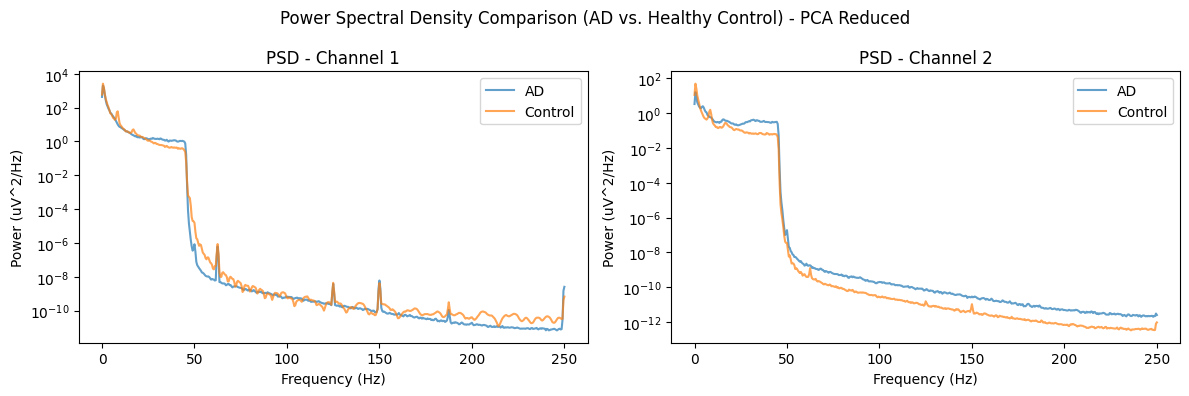

In [25]:
available_channels = min(processed_Control_pca.shape[0], processed_AD_pca.shape[0])  # 取最小通道数

plt.figure(figsize=(12, 4))
for i in range(available_channels):
    f_ad, psd_ad = welch(processed_AD_pca[i], fs, nperseg=fs*2)
    f_control, psd_control = welch(processed_Control_pca[i], fs, nperseg=fs*2)
    plt.subplot(1, available_channels, i + 1)
    plt.semilogy(f_ad, psd_ad, label="AD", alpha=0.7)
    plt.semilogy(f_control, psd_control, label="Control", alpha=0.7)
    plt.title(f"PSD - Channel {i+1}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (uV^2/Hz)")
    plt.legend()

plt.suptitle("Power Spectral Density Comparison (AD vs. Healthy Control) - PCA Reduced")
plt.tight_layout()
plt.show()

In [27]:
print(f"processed_AD_pca shape: {processed_AD_pca.shape}")
print(f"processed_Control_pca shape: {processed_Control_pca.shape}")


processed_AD_pca shape: (2, 150000)
processed_Control_pca shape: (3, 150000)


In [55]:
processed_AD_pca[1]

array([15.97015334, 11.70102297,  7.14740433, ...,  0.20122615,
        0.25977346,  0.48936539], shape=(150000,))

## Time-Frequency Characteristics

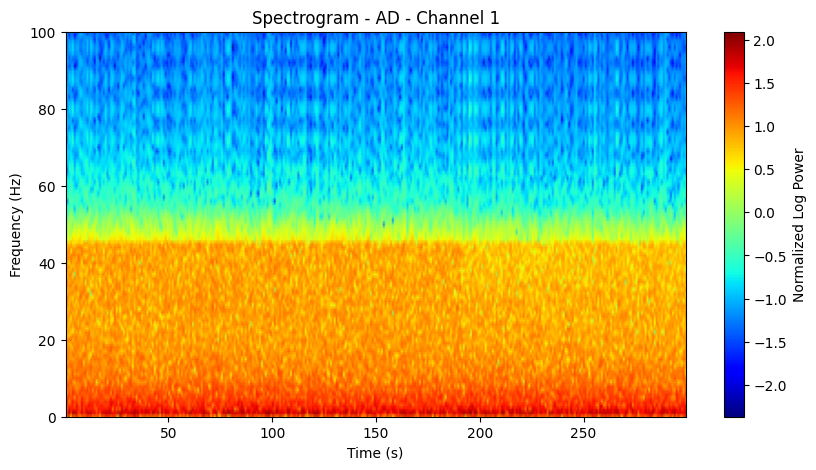

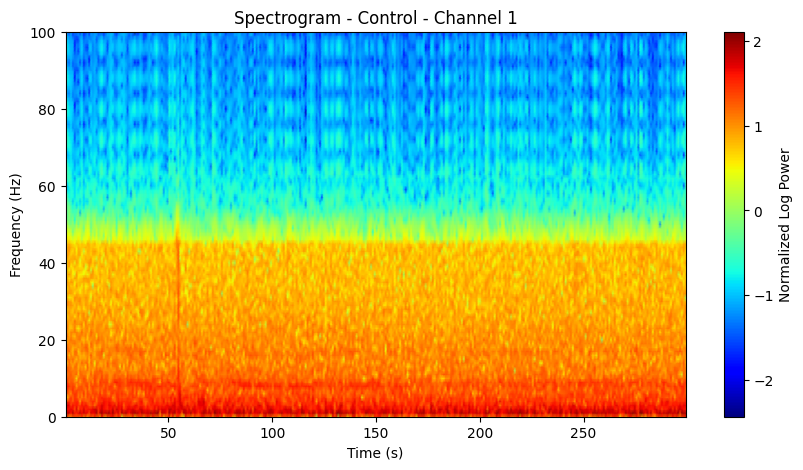

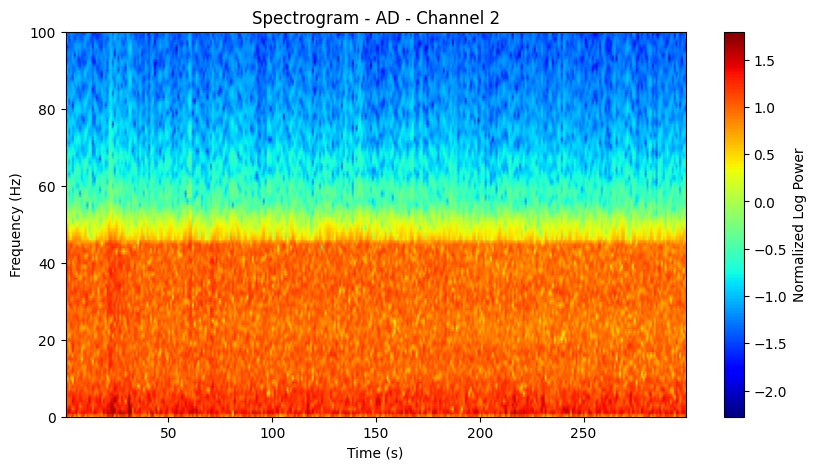

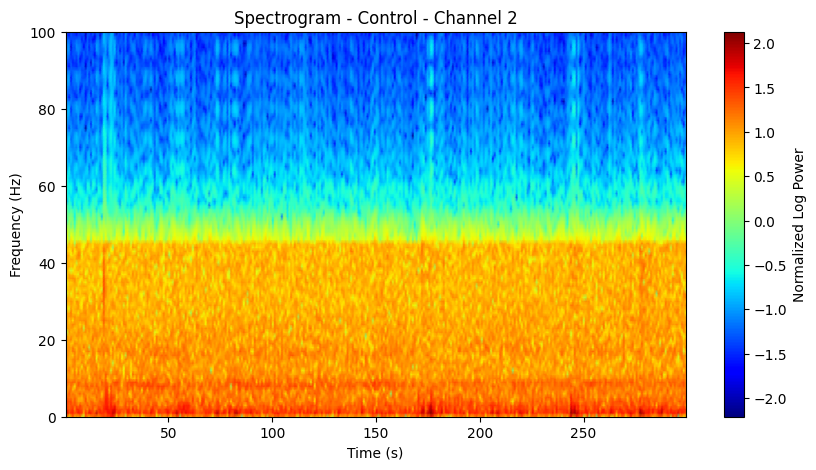

In [33]:
from scipy.signal import spectrogram

import numpy as np

def plot_spectrogram(data, title, fs=500, nperseg=500):
    plt.figure(figsize=(10, 5))
    f, t, Sxx = spectrogram(data, fs=fs, nperseg=nperseg)

    # limit the range of frequency, in case that we have too many unnecessary part
    f_limit = 100
    idx = f <= f_limit
    Sxx = Sxx[idx, :]
    f = f[idx]

    Sxx = np.log(Sxx)
    Sxx -= Sxx.mean()
    Sxx /= Sxx.std()

    plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap='jet')
    plt.colorbar(label='Normalized Log Power')
    plt.title(f'Spectrogram - {title}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, f_limit)
    plt.show()


num_channels_ad = processed_AD_pca.shape[0]
num_channels_control = processed_Control_pca.shape[0]
available_channels = min(num_channels_ad, num_channels_control, 3)

for i in range(available_channels):
    plot_spectrogram(processed_AD_pca[i], f"AD - Channel {i+1}")
    plot_spectrogram(processed_Control_pca[i], f"Control - Channel {i+1}")


Alpha - Freq Range: 8-13Hz, Selected Points: 3
Beta - Freq Range: 13-30Hz, Selected Points: 9


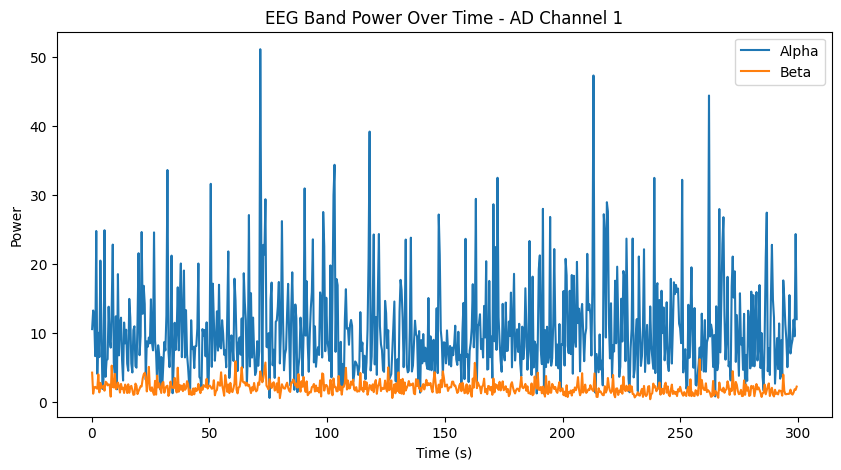

In [46]:
def compute_band_time_power(data, fs=500, bands=bands, nperseg=250):
    f, t, Sxx = spectrogram(data, fs=fs, nperseg=nperseg)
    band_powers = {}

    for band, (low, high) in bands.items():
        idx_band = np.logical_and(f >= low, f <= high)

        print(f"{band} - Freq Range: {low}-{high}Hz, Selected Points: {np.sum(idx_band)}")

        if np.any(idx_band):
            band_powers[band] = np.mean(Sxx[idx_band, :], axis=0)
        else:
            band_powers[band] = np.zeros_like(t)

    return t, band_powers


t, ad_band_powers = compute_band_time_power(processed_AD_pca[0])

plt.figure(figsize=(10, 5))
for band, power in ad_band_powers.items():
    plt.plot(t, power, label=band)
plt.xlabel("Time (s)")
plt.ylabel("Power")
plt.title("EEG Band Power Over Time - AD Channel 1")
plt.legend()
plt.show()


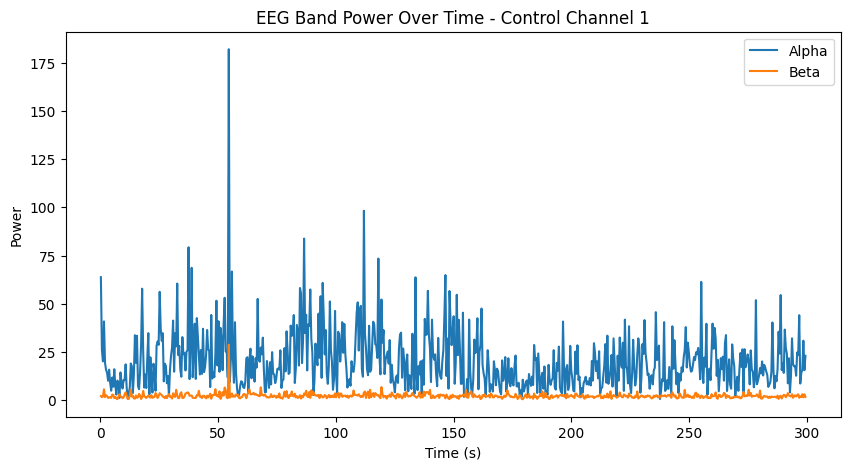

In [35]:
t, ad_band_powers = compute_band_time_power(processed_Control_pca[0])

plt.figure(figsize=(10, 5))
for band, power in ad_band_powers.items():
    plt.plot(t, power, label=band)
plt.xlabel("Time (s)")
plt.ylabel("Power")
plt.title("EEG Band Power Over Time - Control Channel 1")
plt.legend()
plt.show()

D:\UCSD\COGS 118C\finalProject\.venv\Lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


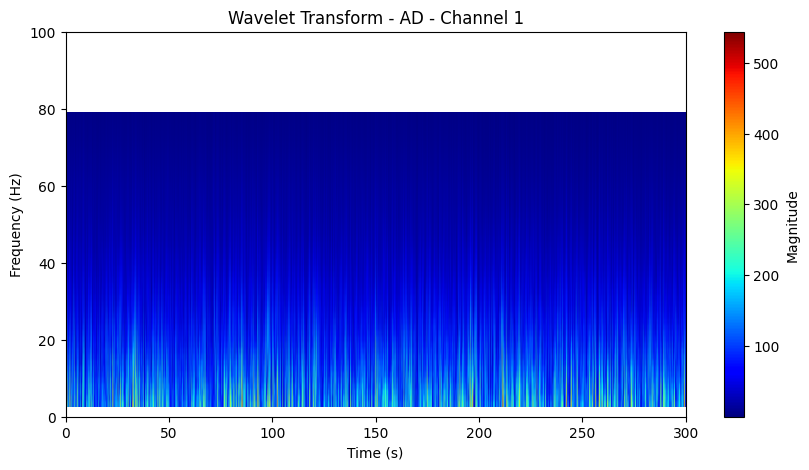

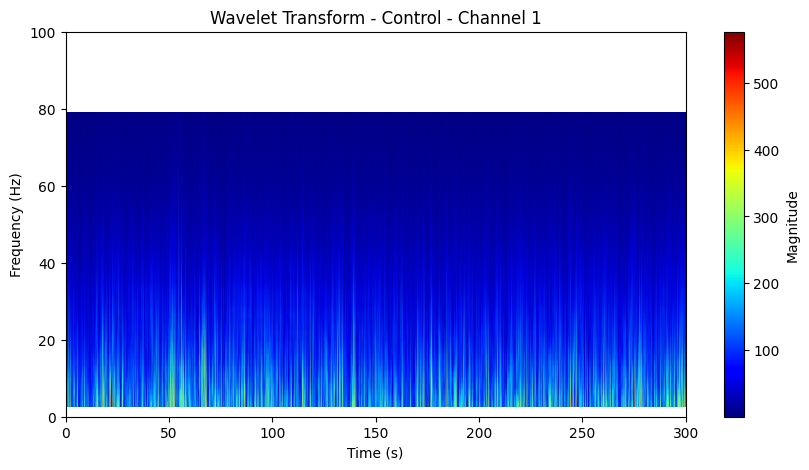

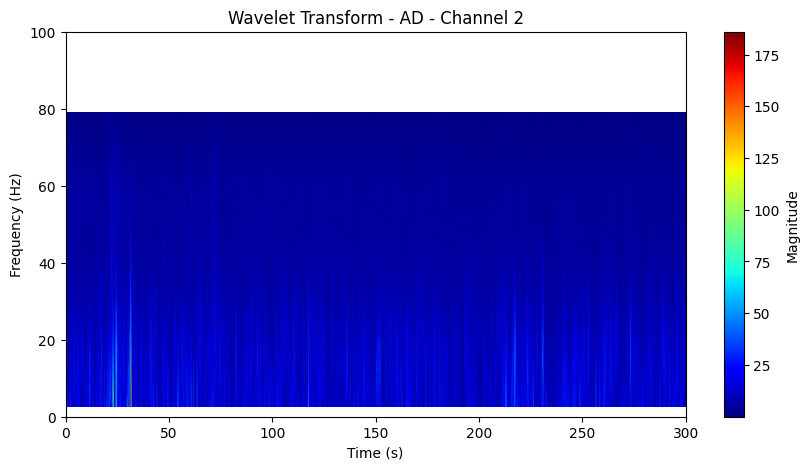

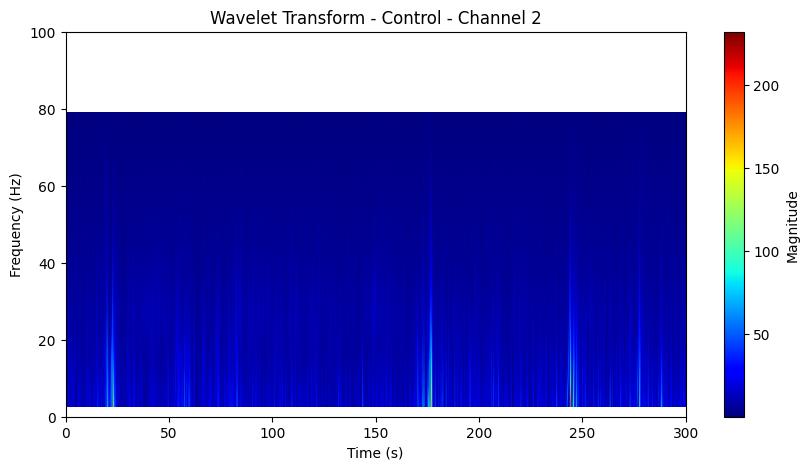

In [54]:
import pywt

def plot_wavelet(data, title, fs=500):
    plt.figure(figsize=(10, 5))
    scales = np.logspace(0.5, 2, 50)  # Logarithmic scaling to focus on EEG bands
 # Adjusted scale range
    coeffs, freqs = pywt.cwt(data, scales, 'cmor', sampling_period=1/fs)  # Use Morlet wavelet
    plt.imshow(np.abs(coeffs), aspect='auto', extent=[0, data.shape[0]/fs, freqs[-1], freqs[0]], cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.ylim(0, 100)  # Limit frequency range
    plt.title(f'Wavelet Transform - {title}')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

# 应用于 AD 和 Control EEG 信号
for i in range(available_channels):
    plot_wavelet(processed_AD_pca[i], f"AD - Channel {i+1}")
    plot_wavelet(processed_Control_pca[i], f"Control - Channel {i+1}")


In [43]:
def compute_band_power(psd, freqs, bands):
    band_power = {}
    total_power = np.trapz(psd, freqs)  # Total power across all frequencies
    for band, (low, high) in bands.items():
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        band_power[band] = np.trapz(psd[idx_band], freqs[idx_band]) / total_power  # Relative power
    return band_power

# Compute relative power for each channel and group
band_powers_ad = {f"Channel {i+1}": compute_band_power(*welch(processed_AD_pca[i], fs, nperseg=fs*2), bands)
                  for i in range(min(3, processed_AD_pca.shape[0], processed_Control_pca.shape[0]))}
band_powers_control = {f"Channel {i+1}": compute_band_power(*welch(processed_Control_pca[i], fs, nperseg=fs*2), bands)
                       for i in range(min(3, processed_AD_pca.shape[0], processed_Control_pca.shape[0]))}

df_ad = pd.DataFrame(band_powers_ad).T
df_control = pd.DataFrame(band_powers_control).T

# Add group labels
df_ad["Group"] = "AD"
df_control["Group"] = "Control"

# Combine both dataframes
df_power_comparison = pd.concat([df_ad, df_control])
print(df_power_comparison)

              Alpha      Beta    Group
Channel 1  0.014300  0.023474       AD
Channel 2 -0.000000 -0.000000       AD
Channel 1  0.009494 -0.004090  Control
Channel 2  0.009226 -0.000000  Control


C:\Users\28593\AppData\Local\Temp\ipykernel_28032\3882905602.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freqs)  # Total power across all frequencies
C:\Users\28593\AppData\Local\Temp\ipykernel_28032\3882905602.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power[band] = np.trapz(psd[idx_band], freqs[idx_band]) / total_power  # Relative power


In [44]:
# Perform t-tests for each frequency band
t_test_results = {}
for band in bands.keys():
    ad_values = df_ad[band].values
    control_values = df_control[band].values
    t_stat, p_value = ttest_ind(ad_values, control_values, equal_var=False)
    t_test_results[band] = {"T-statistic": t_stat, "P-value": p_value}

df_t_tests = pd.DataFrame(t_test_results).T
print(df_t_tests)

       T-statistic   P-value
Alpha    -0.309026  0.809167
Beta      1.156809  0.445166


In [ ]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, min_Hz, max_Hz, fs, order=4):
    nyquist = 0.5 * fs
    low = min_Hz / nyquist
    high = max_Hz / nyquist
    b, a = butter(order, [low, high], btype='band')
    
    return filtfilt(b, a, data)

filtered_alpha = bandpass_filter(processed_AD_pca[0], 8, 13, fs=500)